<h1>Multiple Linear Regression</h1>

<h3> Import the required modules and create our Spark session </h3>

In [1]:
import os
import sys

# mac version of the path
os.environ["JAVA_HOME"] = "jdk8/Contents/Home"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, VectorAssembler, StringIndexer, IDF, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator,TrainValidationSplit, ParamGridBuilder

In [2]:
spark = SparkSession\
    .builder\
    .appName('multiple_linear_regression_model')\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/10 17:03:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<h3>Load our data</h3>

In [3]:
csv_path = "./FuelConsumption.csv"

csv_df = spark.read.csv(csv_path, header=True, inferSchema=True)
csv_df.show(5)

+---------+-----+----------+------------+----------+---------+------------+--------+--------------------+-------------------+--------------------+------------------------+------------+
|MODELYEAR| MAKE|     MODEL|VEHICLECLASS|ENGINESIZE|CYLINDERS|TRANSMISSION|FUELTYPE|FUELCONSUMPTION_CITY|FUELCONSUMPTION_HWY|FUELCONSUMPTION_COMB|FUELCONSUMPTION_COMB_MPG|CO2EMISSIONS|
+---------+-----+----------+------------+----------+---------+------------+--------+--------------------+-------------------+--------------------+------------------------+------------+
|     2014|ACURA|       ILX|     COMPACT|       2.0|        4|         AS5|       Z|                 9.9|                6.7|                 8.5|                      33|         196|
|     2014|ACURA|       ILX|     COMPACT|       2.4|        4|          M6|       Z|                11.2|                7.7|                 9.6|                      29|         221|
|     2014|ACURA|ILX HYBRID|     COMPACT|       1.5|        4|         AV7|

<h3> Simple data preparation, we will check for and drop null values if present</h3>

In [4]:
null_count = csv_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in csv_df.columns])
print("Null value check: ")
null_count.show()

Null value check: 
+---------+----+-----+------------+----------+---------+------------+--------+--------------------+-------------------+--------------------+------------------------+------------+
|MODELYEAR|MAKE|MODEL|VEHICLECLASS|ENGINESIZE|CYLINDERS|TRANSMISSION|FUELTYPE|FUELCONSUMPTION_CITY|FUELCONSUMPTION_HWY|FUELCONSUMPTION_COMB|FUELCONSUMPTION_COMB_MPG|CO2EMISSIONS|
+---------+----+-----+------------+----------+---------+------------+--------+--------------------+-------------------+--------------------+------------------------+------------+
|        0|   0|    0|           0|         0|        0|           0|       0|                   0|                  0|                   0|                       0|           0|
+---------+----+-----+------------+----------+---------+------------+--------+--------------------+-------------------+--------------------+------------------------+------------+



<h3>No nulls in this set, if we wanted to drop all rows with null values however:</h3>

In [5]:
csv_df = csv_df.dropna()

<h3>A visualistation of our numeric data against co2 emissions might be:</h3>

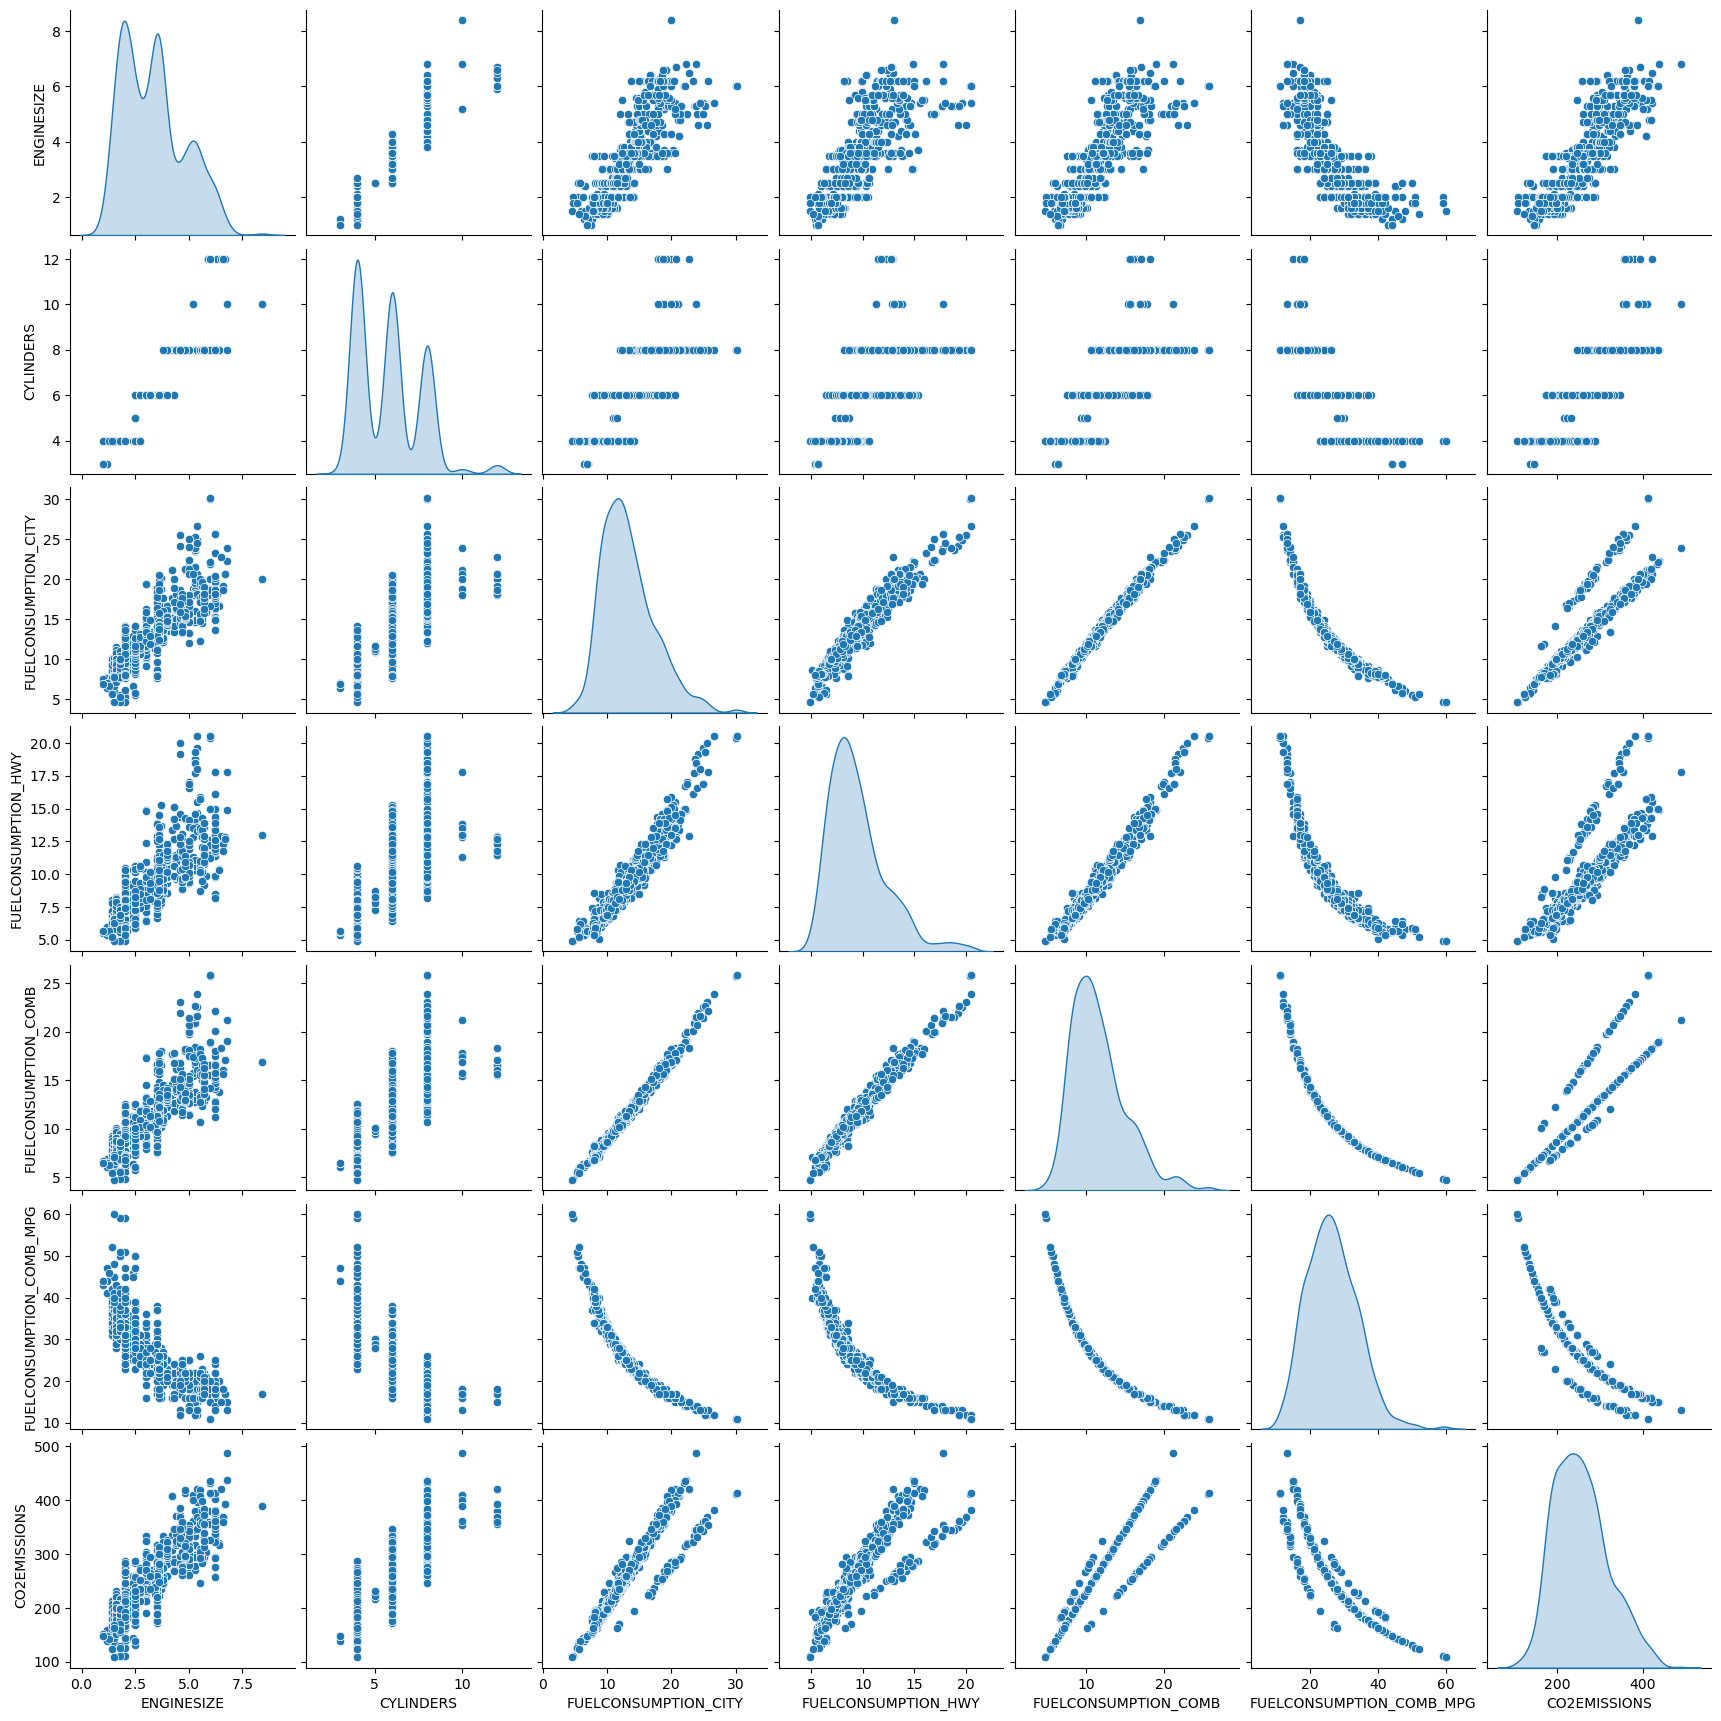

In [6]:
# select numerical columns for correlation visualization
numeric_features = [
    "ENGINESIZE", 
    "CYLINDERS", 
    "FUELCONSUMPTION_CITY",             
    "FUELCONSUMPTION_HWY", 
    "FUELCONSUMPTION_COMB",
    "FUELCONSUMPTION_COMB_MPG",
    "CO2EMISSIONS"
]

# with pair plot
pandas_df = csv_df.toPandas()
sns.pairplot(pandas_df[numeric_features], diag_kind="kde")
plt.show()

<h3>This provides some detailed visual comparison. However, if presenting this to a stakeholder, a heatmap would be my choice</h3>

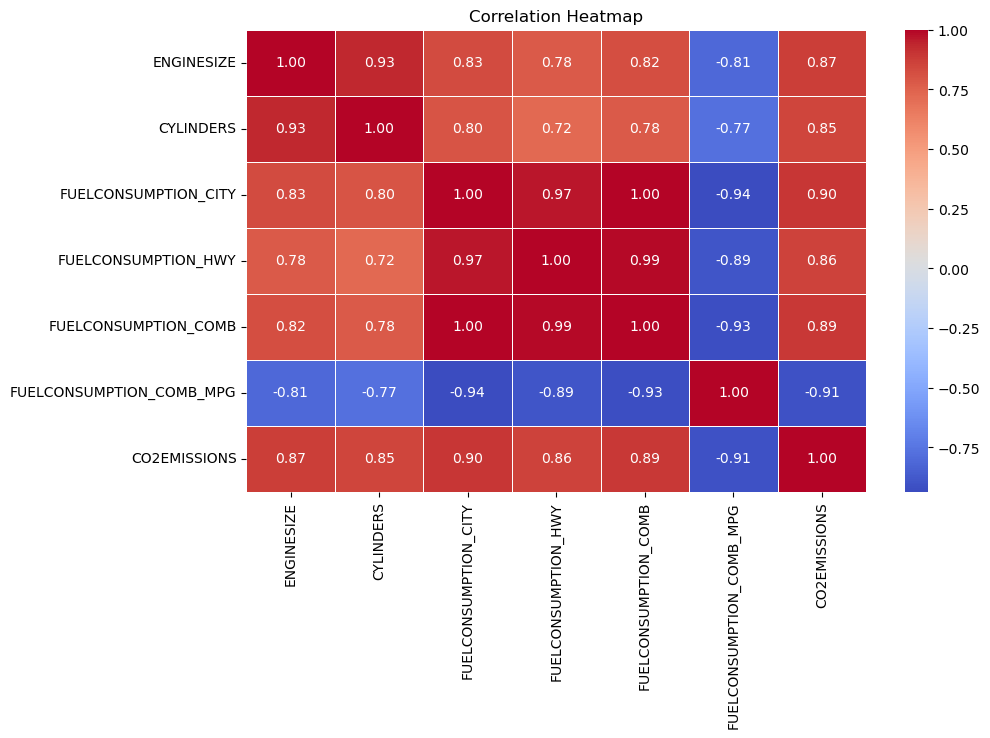

In [7]:
# Compute correlation matrix
corr_matrix = pandas_df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

<h3>We will run the regression against just the numerical data first</h3> 

In [8]:
numeric_df = csv_df.select(
    "MODEL", 
    "MODELYEAR",
    "ENGINESIZE", 
    "CYLINDERS", 
    "FUELCONSUMPTION_CITY",
    "FUELCONSUMPTION_HWY",
    "FUELCONSUMPTION_COMB",
    "FUELCONSUMPTION_COMB_MPG", 
    "CO2EMISSIONS"
)

<h3>Set up our vector of features for the prediction, then split the training and test data in an 80:20 ratio</h3>

In [9]:
assembler = VectorAssembler(
    inputCols=[
                "MODELYEAR", 
                "ENGINESIZE", 
                "CYLINDERS", 
                "FUELCONSUMPTION_CITY", 
                "FUELCONSUMPTION_HWY", 
                "FUELCONSUMPTION_COMB", 
                "FUELCONSUMPTION_COMB_MPG"
            ], 
    outputCol="features"
)
data = assembler.transform(numeric_df)

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

<h3>Create and train our linear regression model</h3>

In [10]:
numeric = LinearRegression(featuresCol="features", labelCol="CO2EMISSIONS", regParam=0.01)
numeric_lr_model = numeric.fit(train_data)

25/06/10 17:04:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/06/10 17:04:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


<h3>Print the model coefficients and intercept value</h3>

In [11]:
coefficients = numeric_lr_model.coefficients
intercept = numeric_lr_model.intercept

print(f"coefficients = {coefficients}\nintercept = {intercept}")

coefficients = [0.0,9.139054231370512,7.234245332600705,-2.9729925535453705,3.0578487808576647,3.185128108061025,-4.064075971834362]
intercept = 264.60673608109903


<h3>Make our predictions on the test data</h3>

In [12]:
numeric_predictions = numeric_lr_model.transform(test_data)
numeric_predictions.show(5)

+-------------------+---------+----------+---------+--------------------+-------------------+--------------------+------------------------+------------+--------------------+------------------+
|              MODEL|MODELYEAR|ENGINESIZE|CYLINDERS|FUELCONSUMPTION_CITY|FUELCONSUMPTION_HWY|FUELCONSUMPTION_COMB|FUELCONSUMPTION_COMB_MPG|CO2EMISSIONS|            features|        prediction|
+-------------------+---------+----------+---------+--------------------+-------------------+--------------------+------------------------+------------+--------------------+------------------+
|     1500 4X4 (MDS)|     2014|       5.7|        8|                16.3|               11.5|                14.1|                      20|         324|[2014.0,5.7,8.0,1...| 324.9075771047634|
|       1500 4X4 FFV|     2014|       3.6|        6|                20.5|               14.5|                17.8|                      16|         285|[2014.0,3.6,6.0,2...| 315.9753280585296|
|           1500 FFV|     2014|    

<h3>Perform R-Squared evaluation on our model to test the models quality. R-Squared captures the proportion of
the total variation in the dependant variable(s)</h3>

In [13]:
# pick the columns we want to check against
numeric_epsilon = numeric_predictions.select("prediction", "CO2EMISSIONS")

# set up the evaluator
evaluator = RegressionEvaluator(
    labelCol = "CO2EMISSIONS",
    predictionCol="prediction",
    metricName="r2"
)

e = evaluator.evaluate(numeric_epsilon)

print(f"{round(e * 100, 2)}% of variance is explained in this model")

90.94% of variance is explained in this model


<h3>Using all the numeric values from the dataset, we can see our model covers 90.94% of the variance.<br></h3>
<br>
<h4>Text values cannot be used directly to further improve our result, but we can use encoding to provide numeric alterative values for that text, in this example onehotencoder.<br>
<br>
While simple id indexes can be used, they can also be misinterpreted. If dog = 1, and cat = 2, does 2 x dog = cat? 
Clearly not, but machine learning may not see this in context.</h4>

<h3>We will prepare out features for encoding, first dividing into categorical and numerical:<h3>

In [14]:
categorical_features = [
    "MAKE", 
    "MODEL", 
    "VEHICLECLASS", 
    "TRANSMISSION", 
    "FUELTYPE"
]

numeric_features = [
    "MODELYEAR", 
    "ENGINESIZE", 
    "CYLINDERS", 
    "FUELCONSUMPTION_CITY", 
    "FUELCONSUMPTION_HWY",
    "FUELCONSUMPTION_COMB",
    "FUELCONSUMPTION_COMB_MPG"
]

+ ***StringIndexer*** is a feature transformer that converts categorical string variables into numerical indices, making it useful for handling categorical features in machine learning algorithms that require numerical input. It is used when preparing data for non-natively handling algorithms like regression or support vector machines, and to maintain an ordinal relationship among categories.
+ ***OneHotEncoder*** is a feature transformer that converts categorical indices into a sparse vector, representing each category as a one-hot encoded vector. This helps avoid the ordinality issue introduced by StringIndexer when categories do not have an ordinal relationship. It is used after converting categorical variables to numerical indices, for algorithms that require or perform better with one-hot encoded features, and when categorical variables do not have an inherent ordinal relationship.

<h3>Create and set up the features<h3>

In [15]:
stages = []

for cat_feature in categorical_features:
    string_indexer = StringIndexer(inputCol=cat_feature, outputCol=f"{cat_feature}Index")
    encoder = OneHotEncoder(inputCol=f"{cat_feature}Index", outputCol=f"{cat_feature}Vec")
    stages += [string_indexer, encoder]

In [16]:
all_features = numeric_features + [f"{cat}Vec" for cat in categorical_features]

assembler = VectorAssembler(inputCols=all_features, outputCol="features")

stages += [assembler]

<h3>Build the pipeline model</h3>

In [17]:
_pipeline = Pipeline(stages=stages)

In [18]:
transformed_data = _pipeline.fit(csv_df).transform(csv_df)
transformed_data.show(5)

+---------+-----+----------+------------+----------+---------+------------+--------+--------------------+-------------------+--------------------+------------------------+------------+---------+---------------+----------+-----------------+-----------------+---------------+-----------------+---------------+-------------+-------------+--------------------+
|MODELYEAR| MAKE|     MODEL|VEHICLECLASS|ENGINESIZE|CYLINDERS|TRANSMISSION|FUELTYPE|FUELCONSUMPTION_CITY|FUELCONSUMPTION_HWY|FUELCONSUMPTION_COMB|FUELCONSUMPTION_COMB_MPG|CO2EMISSIONS|MAKEIndex|        MAKEVec|MODELIndex|         MODELVec|VEHICLECLASSIndex|VEHICLECLASSVec|TRANSMISSIONIndex|TRANSMISSIONVec|FUELTYPEIndex|  FUELTYPEVec|            features|
+---------+-----+----------+------------+----------+---------+------------+--------+--------------------+-------------------+--------------------+------------------------+------------+---------+---------------+----------+-----------------+-----------------+---------------+-------------

<h3>As before, we will visualise the data, now using the numeric indexes for categorical columns:</h3>

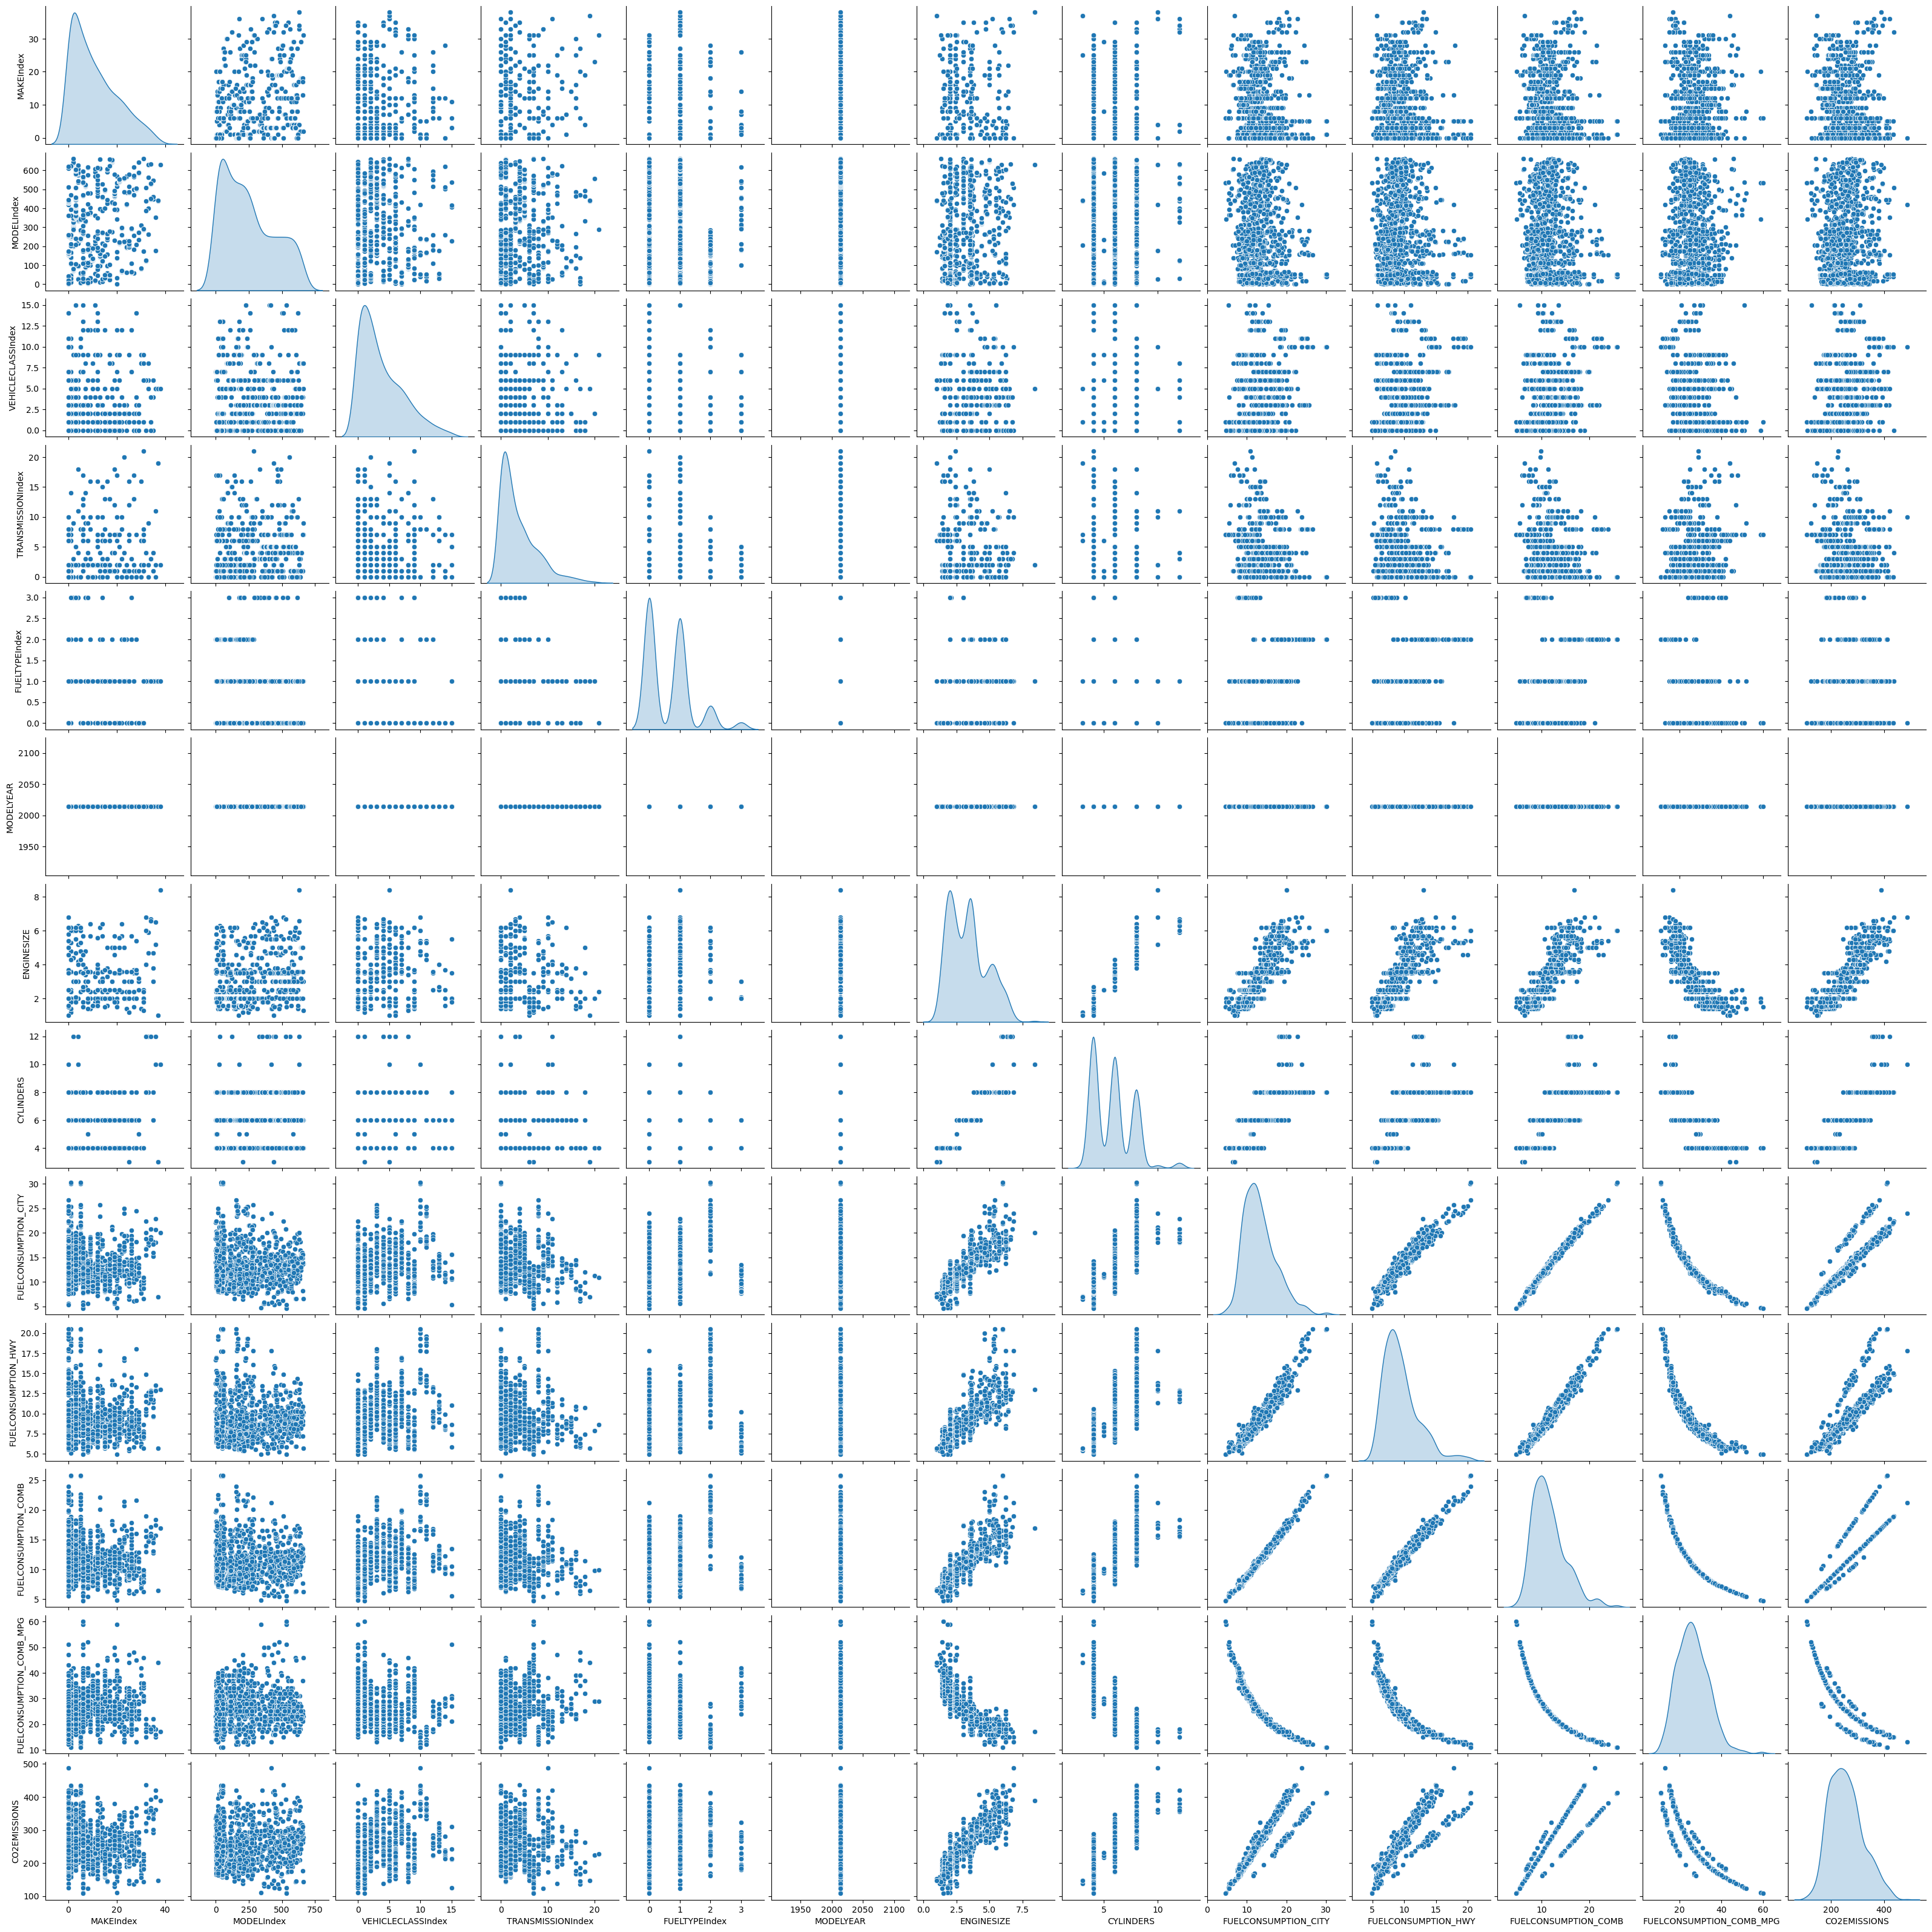

In [19]:
# select numerical columns for correlation visualization
all_features = [
    "MAKEIndex",
    "MODELIndex",
    "VEHICLECLASSIndex",
    "TRANSMISSIONIndex",
    "FUELTYPEIndex",
    "MODELYEAR",
    "ENGINESIZE", 
    "CYLINDERS", 
    "FUELCONSUMPTION_CITY",             
    "FUELCONSUMPTION_HWY", 
    "FUELCONSUMPTION_COMB",
    "FUELCONSUMPTION_COMB_MPG",
    "CO2EMISSIONS"
]

# with pair plot
pandas_df = transformed_data.toPandas()
features_list = pandas_df.columns.to_list()
sns.pairplot(pandas_df[all_features], diag_kind="kde")
plt.show()

<h3>And as a heatmap</h3>

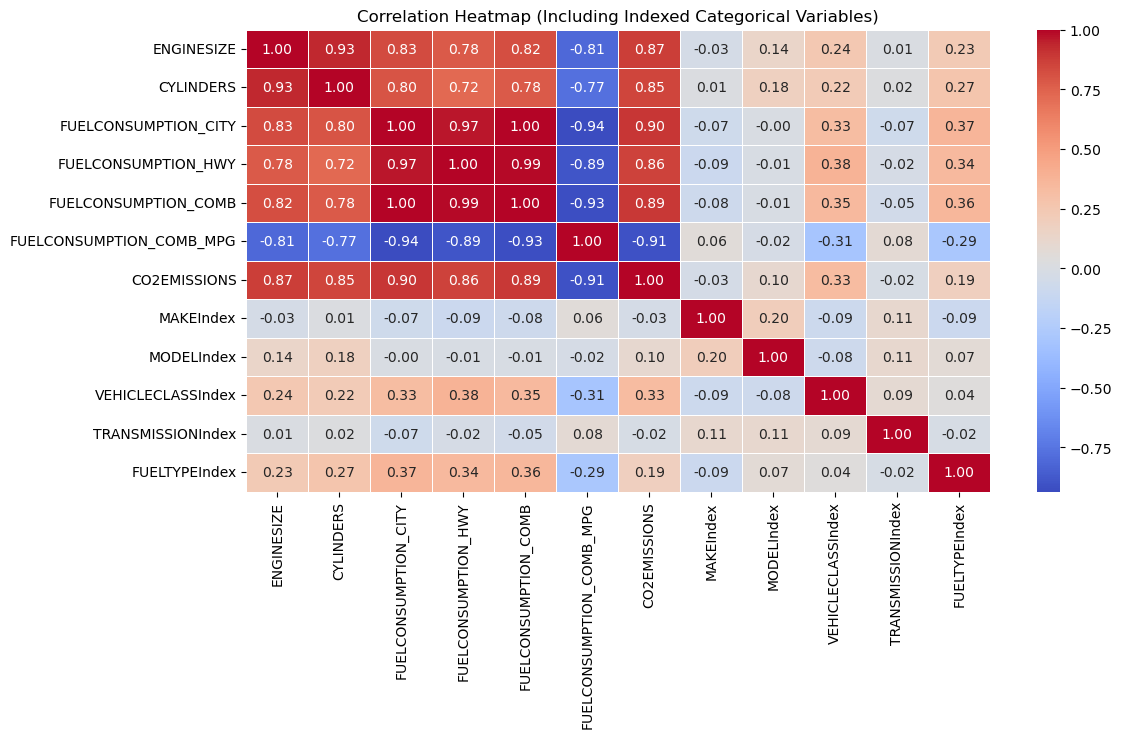

In [20]:
# there is almost certainly better way to do this
num_df = df_numeric = pandas_df.drop(columns=[
                                        "MAKE", 
                                        "MODEL",
                                        "MODELYEAR", 
                                        "VEHICLECLASS", 
                                        "TRANSMISSION", 
                                        "FUELTYPE",
                                        "MAKEVec",
                                        "MODELVec",
                                        "VEHICLECLASSVec",
                                        "TRANSMISSIONVec",
                                        "FUELTYPEVec",
                                        "features"
                                    ])
corr_matrix = num_df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Including Indexed Categorical Variables)")
plt.show()

<h3>Prepare our final dataset for modelling</h3>

In [21]:
final_data = transformed_data.select("features", "CO2EMISSIONS")

train_data, test_data = final_data.randomSplit([0.8,0.2],seed=42)

<h3>Create and train our model</h3>

In [22]:
mlr = LinearRegression(featuresCol="features", labelCol="CO2EMISSIONS", regParam=0.01)

mlr_model = mlr.fit(train_data)

<h3>Make our predictions using all the available data</h3>

In [23]:
mlr_predictions = mlr_model.transform(test_data)
mlr_predictions.select("CO2EMISSIONS", "prediction").show(5)

+------------+-----------------+
|CO2EMISSIONS|       prediction|
+------------+-----------------+
|         264|265.3888306385309|
|         264|266.7207740561292|
|         308|309.8931373418359|
|         340|339.8242722074872|
|         165|162.6295881275123|
+------------+-----------------+
only showing top 5 rows



<h3>Again we can evaluate our model using R-Squared to measure how well it fits the variance:</h3>

In [24]:
mlr_epsilon = mlr_predictions.select("prediction", "CO2EMISSIONS")

# set up the evaluator
evaluator = RegressionEvaluator(
    labelCol = "CO2EMISSIONS",
    predictionCol="prediction",
    metricName="r2"
)

e = evaluator.evaluate(mlr_epsilon)

print(f"{round(e * 100, 2)}% of variance is explained in this model")

97.59% of variance is explained in this model


<h3>With our text data included using onehotencoder, we now have a 97.59% R-Squared evaluation, improving our numeric 
data only model by 7.05%.<br><br>
This looks like our work is complete, but referencing back to our heatmaps, some of the values we've included had a negative correlation.
We may not want our model affected by these, but the correlation may improve as the data set grows. We will go once more to test by removing:<br></h3>
<pre>FUELCONSUMPTION_COMB_MPG</pre>
<pre>MODELYEAR</pre>
<pre>MAKE</pre>
<pre>TRANSMISSION</pre>

In [25]:
categorical_features = [
    "MODEL", 
    "VEHICLECLASS", 
    "FUELTYPE"
]

numeric_features = [
    "ENGINESIZE", 
    "CYLINDERS", 
    "FUELCONSUMPTION_CITY", 
    "FUELCONSUMPTION_HWY",
    "FUELCONSUMPTION_COMB",
]

stages = []

for cat_feature in categorical_features:
    string_indexer = StringIndexer(inputCol=cat_feature, outputCol=f"{cat_feature}Index")
    encoder = OneHotEncoder(inputCol=f"{cat_feature}Index", outputCol=f"{cat_feature}Vec")
    stages += [string_indexer, encoder]

all_features = numeric_features + [f"{cat}Vec" for cat in categorical_features]

assembler = VectorAssembler(inputCols=all_features, outputCol="features")

stages += [assembler]

_pipeline = Pipeline(stages=stages)

transformed_data = _pipeline.fit(csv_df).transform(csv_df)

final_data = transformed_data.select("features", "CO2EMISSIONS")

train_data, test_data = final_data.randomSplit([0.8,0.2],seed=42)

mlr = LinearRegression(featuresCol="features", labelCol="CO2EMISSIONS", regParam=0.01)

mlr_model = mlr.fit(train_data)

mlr_predictions = mlr_model.transform(test_data)

mlr_epsilon = mlr_predictions.select("prediction", "CO2EMISSIONS")

# set up the evaluator
evaluator = RegressionEvaluator(
    labelCol = "CO2EMISSIONS",
    predictionCol="prediction",
    metricName="r2"
)

e = evaluator.evaluate(mlr_epsilon)

print(f"{round(e * 100, 2)}% of variance is explained in this model")

96.88% of variance is explained in this model


<h3>Our R-Squared has dropped slightly after removing the negative correlation values, but only by a small amount. This suggests that while negative these values may have had an overall positive affect on our predictions. We should consider replacing the weak negative correllations:<br></h3>
<pre>MODELYEAR</pre>
<pre>MAKE</pre>
<pre>TRANSMISSION</pre>

In [26]:
categorical_features = [
    "MODEL", 
    "VEHICLECLASS", 
    "MAKE",
    "TRANSMISSION",
    "FUELTYPE"
]

numeric_features = [
    "ENGINESIZE", 
    "CYLINDERS", 
    "FUELCONSUMPTION_CITY", 
    "FUELCONSUMPTION_HWY",
    "FUELCONSUMPTION_COMB",
]

stages = []

for cat_feature in categorical_features:
    string_indexer = StringIndexer(inputCol=cat_feature, outputCol=f"{cat_feature}Index")
    encoder = OneHotEncoder(inputCol=f"{cat_feature}Index", outputCol=f"{cat_feature}Vec")
    stages += [string_indexer, encoder]

all_features = numeric_features + [f"{cat}Vec" for cat in categorical_features]

assembler = VectorAssembler(inputCols=all_features, outputCol="features")

stages += [assembler]

_pipeline = Pipeline(stages=stages)

transformed_data = _pipeline.fit(csv_df).transform(csv_df)

final_data = transformed_data.select("features", "CO2EMISSIONS")

train_data, test_data = final_data.randomSplit([0.8,0.2],seed=42)

mlr = LinearRegression(featuresCol="features", labelCol="CO2EMISSIONS", regParam=0.01)

mlr_model = mlr.fit(train_data)

mlr_predictions = mlr_model.transform(test_data)

mlr_epsilon = mlr_predictions.select("prediction", "CO2EMISSIONS")

# set up the evaluator
evaluator = RegressionEvaluator(
    labelCol = "CO2EMISSIONS",
    predictionCol="prediction",
    metricName="r2"
)

e = evaluator.evaluate(mlr_epsilon)

print(f"{round(e * 100, 2)}% of variance is explained in this model")

97.01% of variance is explained in this model


<h3>Again this is slightly lower than when not using the FUELCONSUMPTION_COMB_MPG column, by 0.58%. <br>
Checking my result with online resources as I do not recall covering this point (we may have done), the <br>
strong negative correlation of FUELCONSUMPTION_COMB_MPG being -0.91 is clearly a strong predictive feature <br>
so should be kept.<br><br>
So, once more, we run the best known model training for this dataset</h3>

In [27]:
categorical_features = [
    "MODEL", 
    "VEHICLECLASS", 
    "MAKE",
    "TRANSMISSION",
    "FUELTYPE"
]

numeric_features = [
    "MODELYEAR",
    "ENGINESIZE", 
    "CYLINDERS", 
    "FUELCONSUMPTION_CITY", 
    "FUELCONSUMPTION_HWY",
    "FUELCONSUMPTION_COMB",
    "FUELCONSUMPTION_COMB_MPG"
]

stages = []

for cat_feature in categorical_features:
    string_indexer = StringIndexer(inputCol=cat_feature, outputCol=f"{cat_feature}Index")
    encoder = OneHotEncoder(inputCol=f"{cat_feature}Index", outputCol=f"{cat_feature}Vec")
    stages += [string_indexer, encoder]

all_features = numeric_features + [f"{cat}Vec" for cat in categorical_features]

assembler = VectorAssembler(inputCols=all_features, outputCol="features")

stages += [assembler]

_pipeline = Pipeline(stages=stages)

transformed_data = _pipeline.fit(csv_df).transform(csv_df)

final_data = transformed_data.select("features", "CO2EMISSIONS")

train_data, test_data = final_data.randomSplit([0.8,0.2],seed=42)

mlr = LinearRegression(featuresCol="features", labelCol="CO2EMISSIONS", regParam=0.01)

mlr_model = mlr.fit(train_data)

mlr_predictions = mlr_model.transform(test_data)

mlr_epsilon = mlr_predictions.select("prediction", "CO2EMISSIONS")

# set up the evaluator
evaluator = RegressionEvaluator(
    labelCol = "CO2EMISSIONS",
    predictionCol="prediction",
    metricName="r2"
)

e = evaluator.evaluate(mlr_epsilon)

print(f"{round(e * 100, 2)}% of variance is explained in this model")

97.22% of variance is explained in this model


<h3>With the data provided, we have a reasonable basis for predicting CO2 emissions.</h3>

In [28]:
spark.stop()